---
title: "Visualizing Gradient Boosting Decision Trees for Classification"
author: "John Kane"
date: '2024-05-31'
slug: visualizing-gradient-boosting
tags:
- machine learning
- gbm
- data visualization
categories:
- machine learning
- gbm
- data visualization
---


## Introduction

Ensemble methods (random forests, gradient boosting machines) have proven to be a winning strategy on Kaggle[^1]. The building blocks of those methods are decision trees, which are generally well understood. It can seem, however, that the ensembling of many trees can produce a sort of magic that allows it to achieve much better performance than a single tree. 

When learning about these methods the discussion moves quickly from declaring them an ensemble of trees into a discussion of hyperparameter tuning, glossing over exactly how or why boosting works so well. When I was first learning the boosting algorithm I came across a blog post by Arthur Charpentier outlining and visualizing in a regression context how boosting gradually moves predictions closer to their target[^2]. Inspired by that post, I've written up this post highlighting the boosting algorithm for classification.

Here I'll highlight the algorithm, write code and fit a model to a toy dataset, visualize the boosting process for both fitted values and loss reduction, and make predictions before briefly discussing implications for cross-validation and model selection in a larger machine learning task. 

## Algorithm

In *An Introduction to Statistical Learning* by James, Witten, Hastie, and Tibshirani they lay out the boosting algorithm on page 322:[^3]

1. Set $\hat{f}(x)$ = 0 and $r_{i}$ = $y_{i}$ for all $i$ in the training set.
2. For $b$ = 1,2,...,B, repeat:
    a. Fit a tree $\hat{f}^{b}$ with d splits (d+1 terminal nodes) to the training data (X,r).
    b. Update $\hat{f}$ by adding in a shrunken version of the new tree:
        $\hat{f}(x)\leftarrow\hat{f}(x)+\lambda\hat{f}^{b}(x)$.
    c. Update the residuals,
        $r_{i}\leftarrow r_{i} - \lambda\hat{f}^{b}(x_{i})$.
3. Output the boosted model,
  $\hat{f}(x) = \sum_{b=1}^{B}\lambda \hat{f}^{b}(x)$
  
## Paraphrasing the Algorithm, Without Mathematical Notation

1. Set all predictions to 0, and calculate the residuals (will be the value of $y$ since all predictions are 0).
2. At each of $B$ iterations do:
    a. Fit a classication tree to the data, mapping the residual, $r$, from the input, $X$. 
    b. Update your predictions by adding a fraction of what the model predicted.
    c. Update the residuals to reflect the shrunken predictions.
3. The final model is the sum of sequentially adding up the predictions from all the fitted trees.


## Data

I'll create a fake dataset with a non-linear relationship between the input and the output. The output `y` takes on a value of either 0 or 1 based on the value of `X`. Here's the data creation step plus a plot.

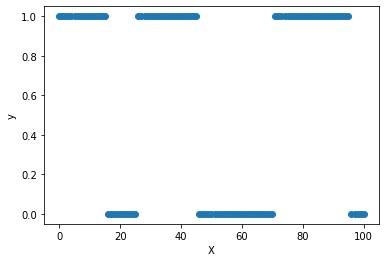

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(0,100,101)

y = np.where(X <= 15, 1,
             np.where(X <= 25, 0,
                      np.where(X <= 45, 1,
                               np.where(X <= 70, 0,
                                        np.where(X <= 95, 1, 0)))))
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## Coding the Algorithm

0. Load libraries, instantiate objects to store intermediate results, write loss function, and set hyperparameters.

In [85]:
trees = []
predictions = []
losses = np.empty(0, dtype=float)
def logloss_func(y, yhat):
    np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))

B = 50
lambda_ = 0.2
maxdepth = 2

1. Set $\hat{f}(x)$ = 0 and $r_{i}$ = $y_{i}$ for all $i$ in the training set.

We'll use `yhat` for predictions and `r` for residuals. 

2. For $b$ = 1,2,...,B, repeat:
    
    a. Fit a tree $\hat{f}^{b}$ with d splits (d+1 terminal nodes) to the training data (X,r).
    
    b. Update $\hat{f}$ by adding in a shrunken version of the new tree:
    $\hat{f}(x)\leftarrow\hat{f}(x)+\lambda\hat{f^{b}}(x)$.
    
    c. Update the residuals,
    $r_{i}\leftarrow r_{i} - \lambda\hat{f}^{b}(x_{i})$.

In [86]:
# reshape X
X_ = X.reshape(-1,1)
from sklearn.tree import DecisionTreeRegressor

for b in range(B+1):
    simple_tree = DecisionTreeRegressor(max_depth = maxdepth)
    print(b)
    # Part a
    simple_tree.fit(X_,r)
    # Part b
    yhat = yhat + lambda_*simple_tree.predict(X_)
    # Part c
    r = r - lambda_*simple_tree.predict(X_)
    trees.append(simple_tree)
    losses = np.append(losses,logloss_func(y,yhat))
    predictions.append(simple_tree.predict(X_))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))
<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))

In [87]:
logloss_func(y,yhat)

<ipython-input-85-9ac6f769783e>:5: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-8) + (1-y)*np.log(1-yhat+1e-8))


In [95]:
np.sum(-y*np.log(yhat+1e-15) + (1-y)*np.log(1-yhat+1e-15))

<ipython-input-95-ac737e2ae88e>:1: RuntimeWarning: invalid value encountered in log
  np.sum(-y*np.log(yhat+1e-15) + (1-y)*np.log(1-yhat+1e-15))


nan

In [93]:
1-yhat

array([-1.99850909e-01, -1.99850909e-01, -1.99850909e-01, -1.99850909e-01,
       -1.99850909e-01, -1.99850909e-01, -1.99850909e-01, -1.99850909e-01,
       -1.99850909e-01, -1.99850909e-01, -1.99850909e-01, -1.99850909e-01,
       -1.99850909e-01, -1.99850909e-01, -1.99850909e-01, -1.99850909e-01,
        9.99634479e-01,  9.99634479e-01,  9.99634479e-01,  9.99634479e-01,
        9.99634479e-01,  9.99634479e-01,  9.99634479e-01,  9.99634479e-01,
        9.99634479e-01,  9.99634479e-01,  2.07960321e-04,  2.07960321e-04,
        2.07960321e-04,  2.07960321e-04,  2.07960321e-04,  2.07960321e-04,
        2.07960321e-04,  2.07960321e-04,  2.07960321e-04,  2.07960321e-04,
        2.07960321e-04,  2.07960321e-04,  2.07960321e-04,  2.07960321e-04,
        2.07960321e-04,  2.07960321e-04,  2.07960321e-04,  2.07960321e-04,
        2.07960321e-04,  2.07960321e-04,  9.99846506e-01,  9.99846506e-01,
        9.99846506e-01,  9.99846506e-01,  9.99846506e-01,  9.99846506e-01,
        9.99846506e-01,  

In [83]:
(1-yhat)*np.log(1-yhat+1e-8)

<ipython-input-83-e5a2977cf388>:1: RuntimeWarning: invalid value encountered in log
  (1-yhat)*np.log(1-yhat+1e-8)


array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.01327707, -0.01327707, -0.01327707, -0.01327707,
       -0.01327707, -0.01327707, -0.01327707, -0.01327707, -0.01327707,
       -0.01327707, -0.04106667, -0.04106667, -0.04106667, -0.04106667,
       -0.04106667, -0.04106667, -0.04106667, -0.04106667, -0.04106667,
       -0.04106667, -0.04106667, -0.04106667, -0.04106667, -0.04106667,
       -0.04106667, -0.04106667, -0.04106667, -0.04106667, -0.04106667,
       -0.04106667, -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 ,
       -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 ,
       -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 ,
       -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 ,
       -0.0073803 , -0.0073803 , -0.0073803 , -0.0073803 , -0.00

In [76]:
predictions

[array([ 0.31993066,  0.31993066,  0.31993066,  0.31993066,  0.31993066,
         0.31993066,  0.31993066,  0.31993066,  0.31993066,  0.31993066,
         0.31993066,  0.31993066,  0.31993066,  0.31993066,  0.31993066,
         0.31993066,  0.31993066,  0.31993066,  0.31993066,  0.31993066,
         0.31993066,  0.31993066,  0.31993066,  0.31993066,  0.31993066,
         0.31993066,  0.72608451,  0.72608451,  0.72608451,  0.72608451,
         0.72608451,  0.72608451,  0.72608451,  0.72608451,  0.72608451,
         0.72608451,  0.72608451,  0.72608451,  0.72608451,  0.72608451,
         0.72608451,  0.72608451,  0.72608451,  0.72608451,  0.72608451,
         0.72608451, -0.07391549, -0.07391549, -0.07391549, -0.07391549,
        -0.07391549, -0.07391549, -0.07391549, -0.07391549, -0.07391549,
        -0.07391549, -0.07391549, -0.07391549, -0.07391549, -0.07391549,
        -0.07391549, -0.07391549, -0.07391549, -0.07391549, -0.07391549,
        -0.07391549, -0.07391549, -0.07391549, -0.0

3. Output the boosted model,
  $\hat{f}(x) = \sum_{b=1}^{B}\lambda \hat{f}^{b}(x)$

In [14]:
boost_prediction <- function(X,num_trees){
  pred <- numeric(length = length(X))
  for(j in c(1:num_trees)){
    pred <- pred + lambda*predict(trees[[j]], newdata = data.frame(X = X))
  }
  return(pred)
}

SyntaxError: invalid syntax (<ipython-input-14-3ed8335a598f>, line 1)

## Visualize 

The boosting procedure is an iterative one, which lends itself nicely to visualization. In Step 2 of the code we saved the values of the loss function after every iteration, as well as the fitted values of the model. Here we'll construct a visualization of the process. This visualization is made possible by the fantastic `gganimate` and `magick` packages in R.[^4]


In [ ]:
```{r, warning = F, message = F}
library(ggplot2)
library(gganimate)
library(magick)
```

In [ ]:
#### Building visualization datasets


```{r}
loss_plot_data <- tibble(iteration = c(1:B),
                                  loss = losses)

boost_plot_data <- do.call(rbind, predictions)
boost_plot_data$B <- rep(c(1:B), each = length(X))
boost_plot_data$y <- rep(data$y, times = B)
```

In [ ]:
#### Create the individual plots

In [ ]:
```{r}
boost_plot <- ggplot(data = boost_plot_data,
       aes(x = X, y = y),
       colour = 'black') +
  geom_point() +
  geom_point(aes(x = X, y = yhat), colour = 'red') +
  transition_states(B) +
  labs(title = 'Iteration: {closest_state}', subtitle = "Boosting",x = 'X', y = 'y')

boost_gif <- animate(boost_plot, width = 400, height = 400)
```

In [ ]:
```{r}
loss_plot <- ggplot(data = loss_plot_data,
                aes(x = iteration, y = loss),
                colour = 'black') +
  geom_point() +
  geom_line() +
  transition_reveal(along = iteration) +
  shadow_trail(distance = 1/B) +
  labs(title = ' ', subtitle = 'Loss')

loss_gif <- animate(loss_plot,width = 400, height = 400)
```


In [ ]:
#### Combine the gifs and view

In [ ]:
```{r, include = F}
loss_mgif <- image_read(loss_gif)
boost_mgif <- image_read(boost_gif)

combined_gif <- image_append(c(boost_mgif[1], loss_mgif[1]))

for(i in 2:100){
  combined <- image_append(c(boost_mgif[i], loss_mgif[i]))
  combined_gif <- c(combined_gif, combined)
}

magick::image_write(combined_gif, path="/home/john/johnckane.com/static/img/boosting-and-loss.gif")
```

In [ ]:
```{r, eval = FALSE}
loss_mgif <- image_read(loss_gif)
boost_mgif <- image_read(boost_gif)

combined_gif <- image_append(c(boost_mgif[1], loss_mgif[1]))

for(i in 2:100){
  combined <- image_append(c(boost_mgif[i], loss_mgif[i]))
  combined_gif <- c(combined_gif, combined)
}

combined_gif
```

In [ ]:
![](/img/boosting-and-loss.gif)

Almost all of the loss reduction occurs in the first 10 iterations even though there isn't separation of all the six groups of $X$ values until the 22nd iteration. Beyond the 22nd iteration we can see improvement in predictions but the changes are slow and gradual, which is also reflected in the loss reduction graph. By the time we get to the 50th iteration we're in a position where if we draw our decision boundary to be at $\hat{y} = 0.50$ and predict a value of 1 for all values at or above that line and a value of 0 to all points below that line, that we'd achieve 100% accuracy in the classification task.

## Making predictions 

To illustrate the sequential nature of making predictions, I'll generate predictions for five $X$ values, and print out the model's predictions using 5, 10, or 50 trees. Generating predictions was Step 3 in the algorithm.


In [2]:
```{r}
vals_to_predict <- c(5,25,35,60,99)
prediction_tibble <- tibble(x = vals_to_predict,
                            y = data$y[vals_to_predict + 1], # the first value of X is 0 so the index of x is x+1
                            five_trees = sapply(vals_to_predict, boost_prediction, num_trees = 5),
                            ten_trees = sapply(vals_to_predict, boost_prediction, num_trees = 10),
                            fifty_trees = sapply(vals_to_predict, boost_prediction, num_trees = 50))
prediction_tibble
```

SyntaxError: invalid syntax (<ipython-input-2-31cb47e4e2c4>, line 1)

As seen above, where $y=1$ the predictions follow an upward trajectory of continuous improvement. Where $y=0$ however, there is actually a decrease in accuracy going from 5 trees to 10 before becoming more accurate by the time we reach fifty trees. I think this is a function of the fact that maximum tree depth is set to 1, so that any split that includes a mixture of both 0's and 1's in a terminal node will naturally move predictions upward, away from 0, where all predictions began. Over the course of the boosting process splits will be made where the average value in a terminal node is less than current predictions, which will bring the predictions for values where $y=0$ closer to the true value. 


## Applications to validation and test datasets

Before deploying a model it is wise to have an idea of how well it will make predictions on data previously unseen by it. Best practice in this case is to split available data into training, validation, and test datasets. The training dataset is used to fit the model, performance of the model at varying values of hyperparameters is evaluated using the validation dataset, and once a single is model is chosen for deployment, an estimate of model performance on previously unseen data is estimated by using the test dataset. 

It is generally true that model fit metrics strictly improve on the training dataset as model complexity grows. This is not the case with validation datasets. There comes a point the model begins to learn the idiosyncracies of the training data rather than a more general relationship between input features and the output of the data generating mechanism. The appropriate model to use in deployment would be the one that performs the best on the validation dataset, even if it doesn't perform as well on the training dataset. 

Hyperparameter tuning and model selection is not the focus of this post, but several details in this example are relevant to its application. The hyperparameters here are the number of trees ($B$), the value of the learning rate ($\lambda$), and the maximum depth of each tree (1). In this example $\lambda$ and maximum tree depth remained fixed and we iterated our model fitting over $B$ different trees. A fuller treatment would involve fitting multiple models to the training data at varying levels of $\lambda$ and maximum tree depth and comparing model performance on the validation dataset using different number of trees fit (anywhere from $1$ to $B$).


[^1]:Goldbloom, Anthony. ["What algorithms are most successful on Kaggle?"](https://www.kaggle.com/antgoldbloom/what-algorithms-are-most-successful-on-kaggle). Retrieved April 1, 2019. 

[^2]:Charpenter, Arthur (June 26, 2015). ["An Attempt to Understand Boosting Algorithms"](https://freakonometrics.hypotheses.org/19874.Retrieved). _Freakonometrics_. April 1, 2019. 

[^3]:James, Gareth Michael., et al. An Introduction to Statistical Learning with Applications in R. Springer, 2013.

[^4]:Peterson, Thomas Lin (August 17, 2018). ["Animation Composition"](https://github.com/thomasp85/gganimate/wiki/Animation-Composition). Retrieved April 1, 2019. 
